# 网络搭建

In [1]:
import torch
import torch.nn as nn

# 定义一个双卷积块，包含两个3x3的卷积层和ReLU激活函数
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

# 定义一个U-Net模型，包含编码器和解码器
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512, 1024]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()  # 编码器中的卷积层列表
        self.ups = nn.ModuleList()  # 解码器中的卷积层列表

        # 定义编码器中的卷积层
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # 定义解码器中的卷积层
        for feature in reversed(features[:-1]):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2) # 利用转置卷积进行上采样
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # 最后的卷积层
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []  # 用于保存编码器中的特征图

        # 编码器部分
        for i, down in enumerate(self.downs):
            x = down(x)
            skip_connections.append(x)
            if i != len(self.downs)-1:
                x = nn.MaxPool2d(kernel_size=2)(x)

        # 解码器部分
        skip_connections = skip_connections[::-1]
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip = skip_connections[i//2+1]
            if x.shape != skip.shape:
                x = nn.functional.pad(x, (0, skip.shape[3]-x.shape[3], 0, skip.shape[2]-x.shape[2]))
            x = torch.cat((skip, x), dim=1)
            x = self.ups[i+1](x)

        # 最后的卷积层
        x = self.final_conv(x)
        x = torch.sigmoid(x)
        # x = torch.where(x>0.5, torch.tensor(1), torch.tensor(0))
        return x

# 数据装载

In [2]:
# # have a try

# from PIL import Image
# input = Image.open('drive/MyDrive/DRIVE/training/images/21_training.tif')
# label = Image.open('drive/MyDrive/DRIVE/training/1st_manual/21_manual1.gif')
# input.show()
# print('——'*20)
# label.show()


# # 删除文件
# import shutil
# import os

# # 要删除的文件夹路径
# folder_path = '/content/train_pred'

# # 使用shutil.rmtree函数删除文件夹及其子文件夹
# shutil.rmtree(folder_path)


In [3]:
# 装载训练集
import os
from PIL import Image
from torchvision import transforms

# 图像变换函数
transform = transforms.Compose([
    transforms.ToTensor(),  # 将PIL图片转换为PyTorch张量
])

folder_input = 'drive/MyDrive/DRIVE/train_data/images'
folder_label = 'drive/MyDrive/DRIVE/train_data/1st_manual'

# 获取指定文件夹中所有文件的名称列表
input_list = os.listdir(folder_input)
label_list = os.listdir(folder_label)

# 对文件名称列表按照字典序排序
input_list = sorted(input_list)
label_list = sorted(label_list)

# 将排序后的文件名称与文件夹路径拼接成完整的文件地址
input_list = [os.path.join(folder_input, name) for name in input_list]
label_list = [os.path.join(folder_label, name) for name in label_list]

print(input_list)
print(label_list)

batch_input = []
batch_label = []

for img_path in input_list:
    img = Image.open(img_path)
    img_tensor = transform(img)
    # print(img_tensor.max())
    batch_input.append(img_tensor)

for img_path in label_list:
    img = Image.open(img_path)
    img_tensor = transform(img)
    # print(img_tensor.max())
    batch_label.append(img_tensor)

# 将多张图片拼接成一个批次张量，维度为(N, C, H, W)，其中N为批次大小
train_input = torch.stack(batch_input, dim=0)
train_label = torch.stack(batch_label, dim=0)
print(train_input.shape, train_label.shape)

['drive/MyDrive/DRIVE/train_data/images/21_training.tif', 'drive/MyDrive/DRIVE/train_data/images/22_training.tif', 'drive/MyDrive/DRIVE/train_data/images/23_training.tif', 'drive/MyDrive/DRIVE/train_data/images/24_training.tif', 'drive/MyDrive/DRIVE/train_data/images/25_training.tif', 'drive/MyDrive/DRIVE/train_data/images/26_training.tif', 'drive/MyDrive/DRIVE/train_data/images/27_training.tif', 'drive/MyDrive/DRIVE/train_data/images/28_training.tif', 'drive/MyDrive/DRIVE/train_data/images/29_training.tif', 'drive/MyDrive/DRIVE/train_data/images/30_training.tif', 'drive/MyDrive/DRIVE/train_data/images/31_training.tif', 'drive/MyDrive/DRIVE/train_data/images/32_training.tif', 'drive/MyDrive/DRIVE/train_data/images/33_training.tif', 'drive/MyDrive/DRIVE/train_data/images/34_training.tif', 'drive/MyDrive/DRIVE/train_data/images/35_training.tif', 'drive/MyDrive/DRIVE/train_data/images/36_training.tif', 'drive/MyDrive/DRIVE/train_data/images/37_training.tif', 'drive/MyDrive/DRIVE/train_dat

In [4]:
# 装载测试集
# 读取多张图片并将它们拼接成一个批次张量
folder_input = 'drive/MyDrive/DRIVE/test_data/images'
folder_label = 'drive/MyDrive/DRIVE/test_data/1st_manual'
# folder_label = 'drive/MyDrive/DRIVE/test_data/2nd_manual'


# 获取指定文件夹中所有文件的名称列表
input_list = os.listdir(folder_input)
label_list = os.listdir(folder_label)

# 对文件名称列表按照字典序排序
input_list = sorted(input_list)
label_list = sorted(label_list)

# 将排序后的文件名称与文件夹路径拼接成完整的文件地址
input_list = [os.path.join(folder_input, name) for name in input_list]
label_list = [os.path.join(folder_label, name) for name in label_list]

print(input_list)
print(label_list)

batch_input = []
batch_label = []

for img_path in input_list:
    img = Image.open(img_path)
    img_tensor = transform(img)
    # print(img_tensor.max())
    batch_input.append(img_tensor)

for img_path in label_list:
    img = Image.open(img_path)
    img_tensor = transform(img)
    # print(img_tensor.max())
    batch_label.append(img_tensor)

# 将多张图片拼接成一个批次张量，维度为(N, C, H, W)，其中N为批次大小
test_input = torch.stack(batch_input, dim=0)
test_label = torch.stack(batch_label, dim=0)
print(test_input.shape, test_label.shape)

['drive/MyDrive/DRIVE/test_data/images/01_test.tif', 'drive/MyDrive/DRIVE/test_data/images/02_test.tif', 'drive/MyDrive/DRIVE/test_data/images/03_test.tif', 'drive/MyDrive/DRIVE/test_data/images/04_test.tif', 'drive/MyDrive/DRIVE/test_data/images/05_test.tif', 'drive/MyDrive/DRIVE/test_data/images/06_test.tif', 'drive/MyDrive/DRIVE/test_data/images/07_test.tif', 'drive/MyDrive/DRIVE/test_data/images/08_test.tif', 'drive/MyDrive/DRIVE/test_data/images/09_test.tif', 'drive/MyDrive/DRIVE/test_data/images/10_test.tif', 'drive/MyDrive/DRIVE/test_data/images/11_test.tif', 'drive/MyDrive/DRIVE/test_data/images/12_test.tif', 'drive/MyDrive/DRIVE/test_data/images/13_test.tif', 'drive/MyDrive/DRIVE/test_data/images/14_test.tif', 'drive/MyDrive/DRIVE/test_data/images/15_test.tif', 'drive/MyDrive/DRIVE/test_data/images/16_test.tif', 'drive/MyDrive/DRIVE/test_data/images/17_test.tif', 'drive/MyDrive/DRIVE/test_data/images/18_test.tif', 'drive/MyDrive/DRIVE/test_data/images/19_test.tif', 'drive/MyDr

In [5]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, input_data, label_data):
        self.input_data = input_data
        self.label_data = label_data

    def __getitem__(self, index):
        input_image = self.input_data[index]
        label_image = self.label_data[index]
        return input_image, label_image

    def __len__(self):
        return len(self.input_data)

batch_size = 4
train_data = MyDataset(train_input, train_label)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = MyDataset(test_input, test_label)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# 定义优化器与损失函数

In [6]:
import numpy as np
from torch import optim

# 定义损失函数
def dice_coefficient(y_pred, y_true):
    eps = 1.0  # 加一个极小值，避免分母为0
    y_pred = y_pred.contiguous().view(-1)
    y_true = y_true.contiguous().view(-1)
    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum()
    dice = (2.0 * intersection + eps) / (union + eps)
    return dice

def dice_loss(y_pred, y_true):
    return 1 - dice_coefficient(y_pred, y_true)

# loss_fn = nn.CrossEntropyLoss()
loss_fn = dice_loss

# 定义优化器
def get_optimiazer(net):
    return optim.Adam(net.parameters(), lr=0.001)

# 定义训练与测试过程

In [7]:
import matplotlib.pyplot as plt

# 训练过程
def train(train_loader, net, optimizer, loss_fn, num_epochs, device):
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 正向传播
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = loss_fn(outputs, labels)

            # 反向传播和优化
            loss.backward()
            optimizer.step()

            # 打印损失值
            if (epoch+1)%5==0 and (i+1)%5==0:
                print('Epoch [{}/{}], Step [{}/{}], Dice coefficient: {:.6f}, Dice Loss: {:.6f}'
                    .format(epoch + 1, num_epochs, i + 1, len(train_loader), 1-loss.item(), loss.item()))

                correct = 0
                output, label = outputs[-1], labels[-1]
                output = output.permute(1,2,0).detach().cpu().numpy()
                output = np.where(output > 0.5, 1, 0)
                label = label.permute(1,2,0).detach().cpu().numpy()

                # 将图片放在列表中
                imgs = [output, label]

                # 设置每张图片的标题
                titles = ['y_pred', 'y_true']

                # 显示图片
                for i, img in enumerate(imgs):
                    plt.subplot(1, len(imgs), i+1)
                    plt.imshow(img)
                    plt.title(titles[i])
                    plt.axis('off')
                plt.show()
                plt.savefig(f'train_pred/fig_epoch_{epoch+1}.png')



In [8]:
# 测试过程
def test(test_loader, net, device):
    net.eval()
    with torch.no_grad():
        Loss = 0
        pic_order = 0
        batch_order = 0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_fn(outputs, labels)
            print("Batch [{}/{}], Dice coefficient: {:.6f}, Dice Loss: {:.6f}"
            .format(pic_order+1, len(test_loader), 1-loss, loss))
            pic_order += 1
            Loss += loss
            
            for output, label in zip(outputs, labels):
              output = output.permute(1,2,0).detach().cpu().numpy()
              output = np.where(output > 0.5, 1, 0)
              label = label.permute(1,2,0).detach().cpu().numpy()

              # 将图片放在列表中
              imgs = [output, label]

              # 设置每张图片的标题
              titles = ['y_pred', 'y_true']

              # 显示图片
              for i, img in enumerate(imgs):
                  plt.subplot(1, len(imgs), i+1)
                  plt.imshow(img)
                  plt.title(titles[i])
                  plt.axis('off')
              plt.show()
              plt.savefig(f'test_pred/fig_pred_{pic_order+1}.png')
              pic_order += 1

        print('Average Dice coeffitient: {:.6} Average Loss: {:.6}'
        .format(1-Loss/len(train_loader), Loss/len(train_loader)))

# 训练网络模型

Epoch [5/100], Step [5/5], Dice coefficient: 0.315491, Dice Loss: 0.684509


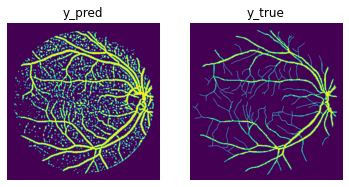

Epoch [10/100], Step [5/5], Dice coefficient: 0.397979, Dice Loss: 0.602021


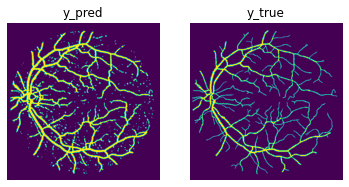

Epoch [15/100], Step [5/5], Dice coefficient: 0.468590, Dice Loss: 0.531410


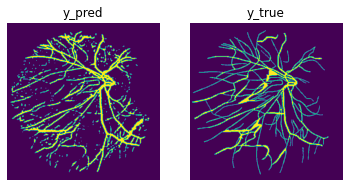

Epoch [20/100], Step [5/5], Dice coefficient: 0.575251, Dice Loss: 0.424749


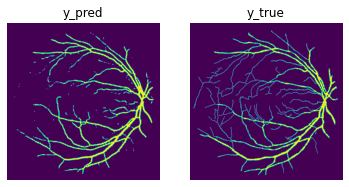

Epoch [25/100], Step [5/5], Dice coefficient: 0.673351, Dice Loss: 0.326649


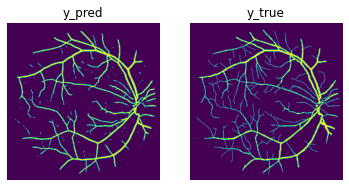

Epoch [30/100], Step [5/5], Dice coefficient: 0.708702, Dice Loss: 0.291298


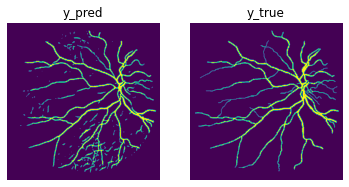

Epoch [35/100], Step [5/5], Dice coefficient: 0.737065, Dice Loss: 0.262935


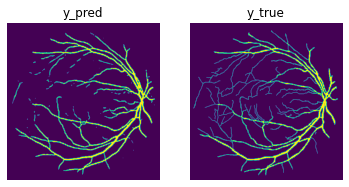

Epoch [40/100], Step [5/5], Dice coefficient: 0.787064, Dice Loss: 0.212936


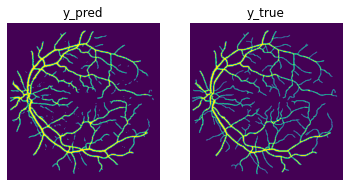

Epoch [45/100], Step [5/5], Dice coefficient: 0.749805, Dice Loss: 0.250195


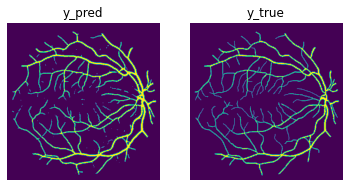

Epoch [50/100], Step [5/5], Dice coefficient: 0.790074, Dice Loss: 0.209926


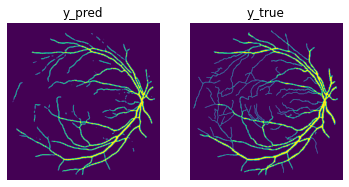

Epoch [55/100], Step [5/5], Dice coefficient: 0.796874, Dice Loss: 0.203126


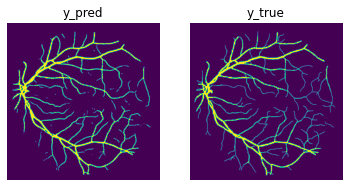

Epoch [60/100], Step [5/5], Dice coefficient: 0.791167, Dice Loss: 0.208833


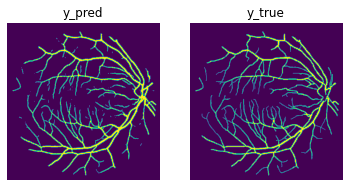

Epoch [65/100], Step [5/5], Dice coefficient: 0.813564, Dice Loss: 0.186436


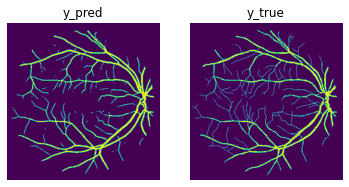

Epoch [70/100], Step [5/5], Dice coefficient: 0.817540, Dice Loss: 0.182460


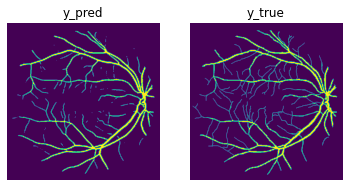

Epoch [75/100], Step [5/5], Dice coefficient: 0.825375, Dice Loss: 0.174625


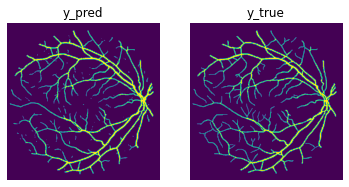

Epoch [80/100], Step [5/5], Dice coefficient: 0.813945, Dice Loss: 0.186055


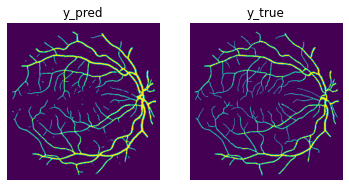

Epoch [85/100], Step [5/5], Dice coefficient: 0.839969, Dice Loss: 0.160031


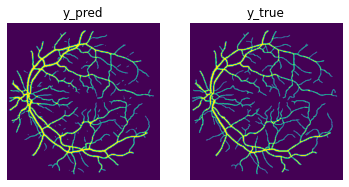

Epoch [90/100], Step [5/5], Dice coefficient: 0.815925, Dice Loss: 0.184075


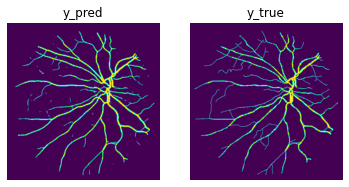

Epoch [95/100], Step [5/5], Dice coefficient: 0.843050, Dice Loss: 0.156950


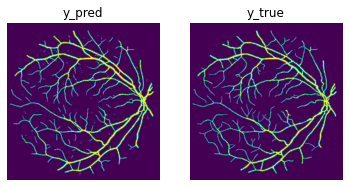

Epoch [100/100], Step [5/5], Dice coefficient: 0.838710, Dice Loss: 0.161290


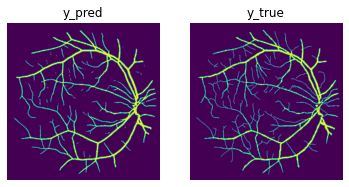

<Figure size 432x288 with 0 Axes>

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  
net = UNet(in_channels=3, out_channels=1)
net.to(device,dtype=torch.float32)

optimizer = get_optimiazer(net)
num_epochs = 100
train(train_loader, net, optimizer, loss_fn, num_epochs, device)

torch.save(net, 'net.pth')

# 测试模型

Batch [1/5], Dice coefficient: 0.789778, Dice Loss: 0.210222


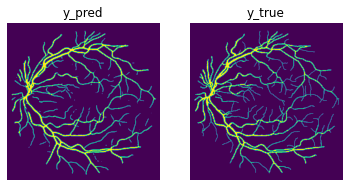

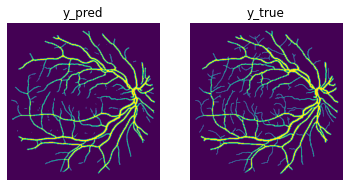

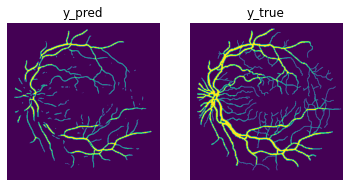

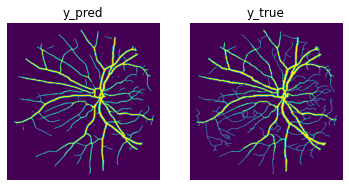

Batch [6/5], Dice coefficient: 0.777655, Dice Loss: 0.222345


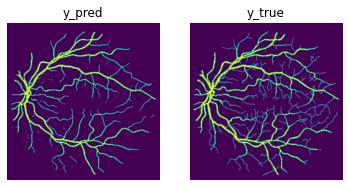

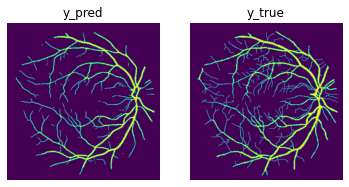

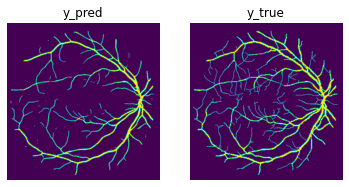

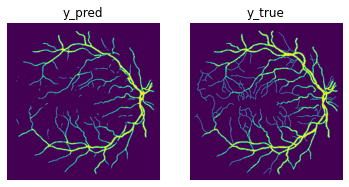

Batch [11/5], Dice coefficient: 0.795195, Dice Loss: 0.204805


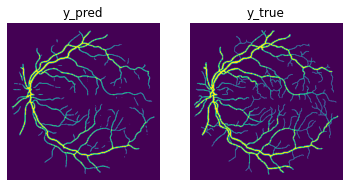

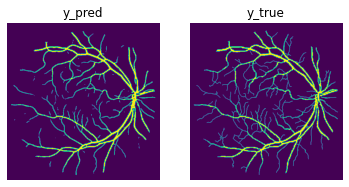

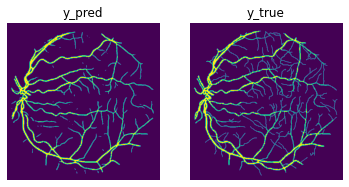

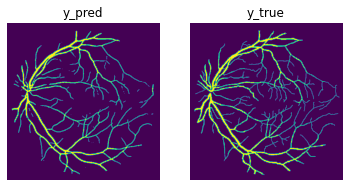

Batch [16/5], Dice coefficient: 0.815989, Dice Loss: 0.184011


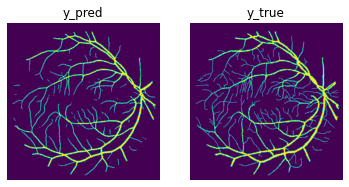

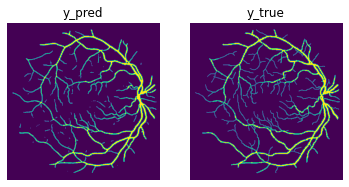

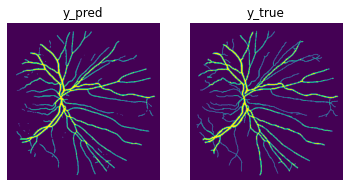

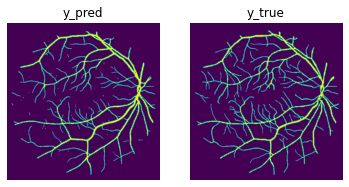

Batch [21/5], Dice coefficient: 0.817293, Dice Loss: 0.182707


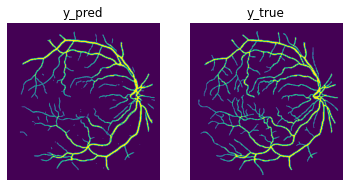

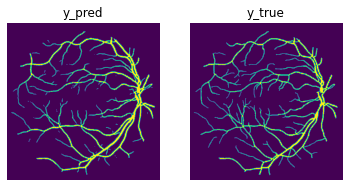

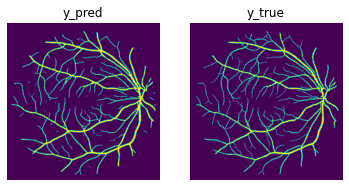

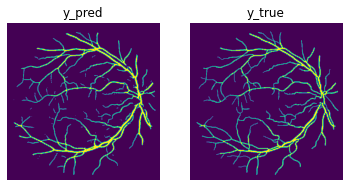

Average Dice coeffitient: 0.799182 Average Loss: 0.200818


<Figure size 432x288 with 0 Axes>

In [10]:
net = torch.load('net.pth')
test(test_loader, net, device)